## Import Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot
from tqdm import tqdm

## Data Prep
Loading data from **MNist** dataset, and define image embeddings \\

In this case, we have two separated datasets, the unpartitioned and partitioned. We perform traditional training on unpartitioned dataset and perform federated learning on partitioned dataset. The partitioned dataset would be splitted into 10 parts.

In [2]:
# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to range [-1, 1]
])

# Load the CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 37379519.29it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define Model
This time we're going to try out a more complicated architecture called **ResNet**, we need to verify if the federated learning still applies on this model.

In [3]:
# Write a ResNet class with the input of 1 channel, 28x28 images and 10 labels
# Write a ResidualBlock class with 2 convolutional layers and a skip connection

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(32)
        self.layer1 = self.make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)
        self.avg_pool = nn.AvgPool2d(7)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn(self.conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [4]:
# Train Function
def train(model, trainloader, criterion, optimizer, epochs=5):
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
    print('Finished Training')

# Test Function
def test(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')
    




In [5]:
# Train non-partitioned model
model = ResNet(ResidualBlock, [2, 2, 2, 2])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train(model, trainloader, criterion, optimizer, epochs=5)
test(model, testloader)


 20%|██        | 1/5 [03:46<15:06, 226.64s/it]

Epoch 1, Loss: 1.4941076732414011


 40%|████      | 2/5 [07:33<11:20, 226.85s/it]

Epoch 2, Loss: 1.1093852592826423


 60%|██████    | 3/5 [11:23<07:36, 228.36s/it]

Epoch 3, Loss: 0.9536904390050445


 80%|████████  | 4/5 [15:23<03:52, 232.84s/it]

Epoch 4, Loss: 0.8458111982313548


100%|██████████| 5/5 [19:21<00:00, 232.35s/it]

Epoch 5, Loss: 0.7620358998510064
Finished Training


Accuracy of the network on the 10000 test images: 70.45%


In [6]:
# Partition the dataset into 5 pieces and train the model on each piece, then combine the models
# Partition the dataset
partitioned_trainset = []
partitioned_trainloader = []
for i in range(5):
    partitioned_trainset.append(torch.utils.data.Subset(trainset, range(i * 10000, (i + 1) * 10000)))
    partitioned_trainloader.append(torch.utils.data.DataLoader(partitioned_trainset[i], batch_size=32, shuffle=True))
    
# Train the models
models = []
for i in range(5):
    model = ResNet(ResidualBlock, [2, 2, 2, 2])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    train(model, partitioned_trainloader[i], criterion, optimizer, epochs=5)
    models.append(model)

# Combine the models using weighted averaging, weight should be assigned according to the loss of each model
# Calculate the loss of each model
losses = []
for i in range(5):
    loss = 0
    for data in partitioned_trainloader[i]:
        inputs, labels = data
        outputs = models[i](inputs)
        loss += criterion(outputs, labels).item()
    losses.append(loss)

# Calculate the weights
weights = []
for loss in losses:
    weights.append(loss / sum(losses))

# Combine the models
combined_model = ResNet(ResidualBlock, [2, 2, 2, 2])
combined_model.load_state_dict(models[0].state_dict())
for i in range(1, 5):
    for combined_param, param in zip(combined_model.parameters(), models[i].parameters()):
        combined_param.data += param.data * weights[i]

# Test the combined model
test(combined_model, testloader)



 20%|██        | 1/5 [00:46<03:07, 46.77s/it]

Epoch 1, Loss: 1.8813023258702823


 40%|████      | 2/5 [01:34<02:22, 47.38s/it]

Epoch 2, Loss: 1.590280613198448


 60%|██████    | 3/5 [02:26<01:38, 49.47s/it]

Epoch 3, Loss: 1.453193822988687


 80%|████████  | 4/5 [03:13<00:48, 48.45s/it]

Epoch 4, Loss: 1.3515115983950825


100%|██████████| 5/5 [03:57<00:00, 47.56s/it]


Epoch 5, Loss: 1.251169834654933
Finished Training


 20%|██        | 1/5 [00:44<02:57, 44.47s/it]

Epoch 1, Loss: 1.8802616546710078


 40%|████      | 2/5 [01:31<02:17, 45.96s/it]

Epoch 2, Loss: 1.6128611682702938


 60%|██████    | 3/5 [02:15<01:30, 45.22s/it]

Epoch 3, Loss: 1.4646636030544489


 80%|████████  | 4/5 [03:00<00:44, 44.87s/it]

Epoch 4, Loss: 1.3351104891719148


100%|██████████| 5/5 [03:45<00:00, 45.01s/it]


Epoch 5, Loss: 1.2396932469008448
Finished Training


 20%|██        | 1/5 [00:44<02:56, 44.01s/it]

Epoch 1, Loss: 1.8661204405105152


 40%|████      | 2/5 [01:27<02:11, 43.93s/it]

Epoch 2, Loss: 1.5997666215744262


 60%|██████    | 3/5 [02:11<01:28, 44.00s/it]

Epoch 3, Loss: 1.4551338642930831


 80%|████████  | 4/5 [02:56<00:44, 44.07s/it]

Epoch 4, Loss: 1.3574443922256128


100%|██████████| 5/5 [03:40<00:00, 44.05s/it]


Epoch 5, Loss: 1.2502188225523732
Finished Training


 20%|██        | 1/5 [00:44<02:57, 44.32s/it]

Epoch 1, Loss: 1.8873273351321966


 40%|████      | 2/5 [01:29<02:14, 44.76s/it]

Epoch 2, Loss: 1.610169639983497


 60%|██████    | 3/5 [02:14<01:29, 44.81s/it]

Epoch 3, Loss: 1.4648205727434005


 80%|████████  | 4/5 [02:58<00:44, 44.53s/it]

Epoch 4, Loss: 1.3529414595506442


100%|██████████| 5/5 [03:42<00:00, 44.51s/it]


Epoch 5, Loss: 1.2601196362187688
Finished Training


 20%|██        | 1/5 [00:48<03:15, 48.84s/it]

Epoch 1, Loss: 1.8699165217030924


 40%|████      | 2/5 [01:33<02:18, 46.20s/it]

Epoch 2, Loss: 1.5900982953489018


 60%|██████    | 3/5 [02:17<01:30, 45.40s/it]

Epoch 3, Loss: 1.4595514021742457


 80%|████████  | 4/5 [03:01<00:44, 44.89s/it]

Epoch 4, Loss: 1.3425819207304202


100%|██████████| 5/5 [03:45<00:00, 45.19s/it]

Epoch 5, Loss: 1.238047354518415
Finished Training


Accuracy of the network on the 10000 test images: 36.09%


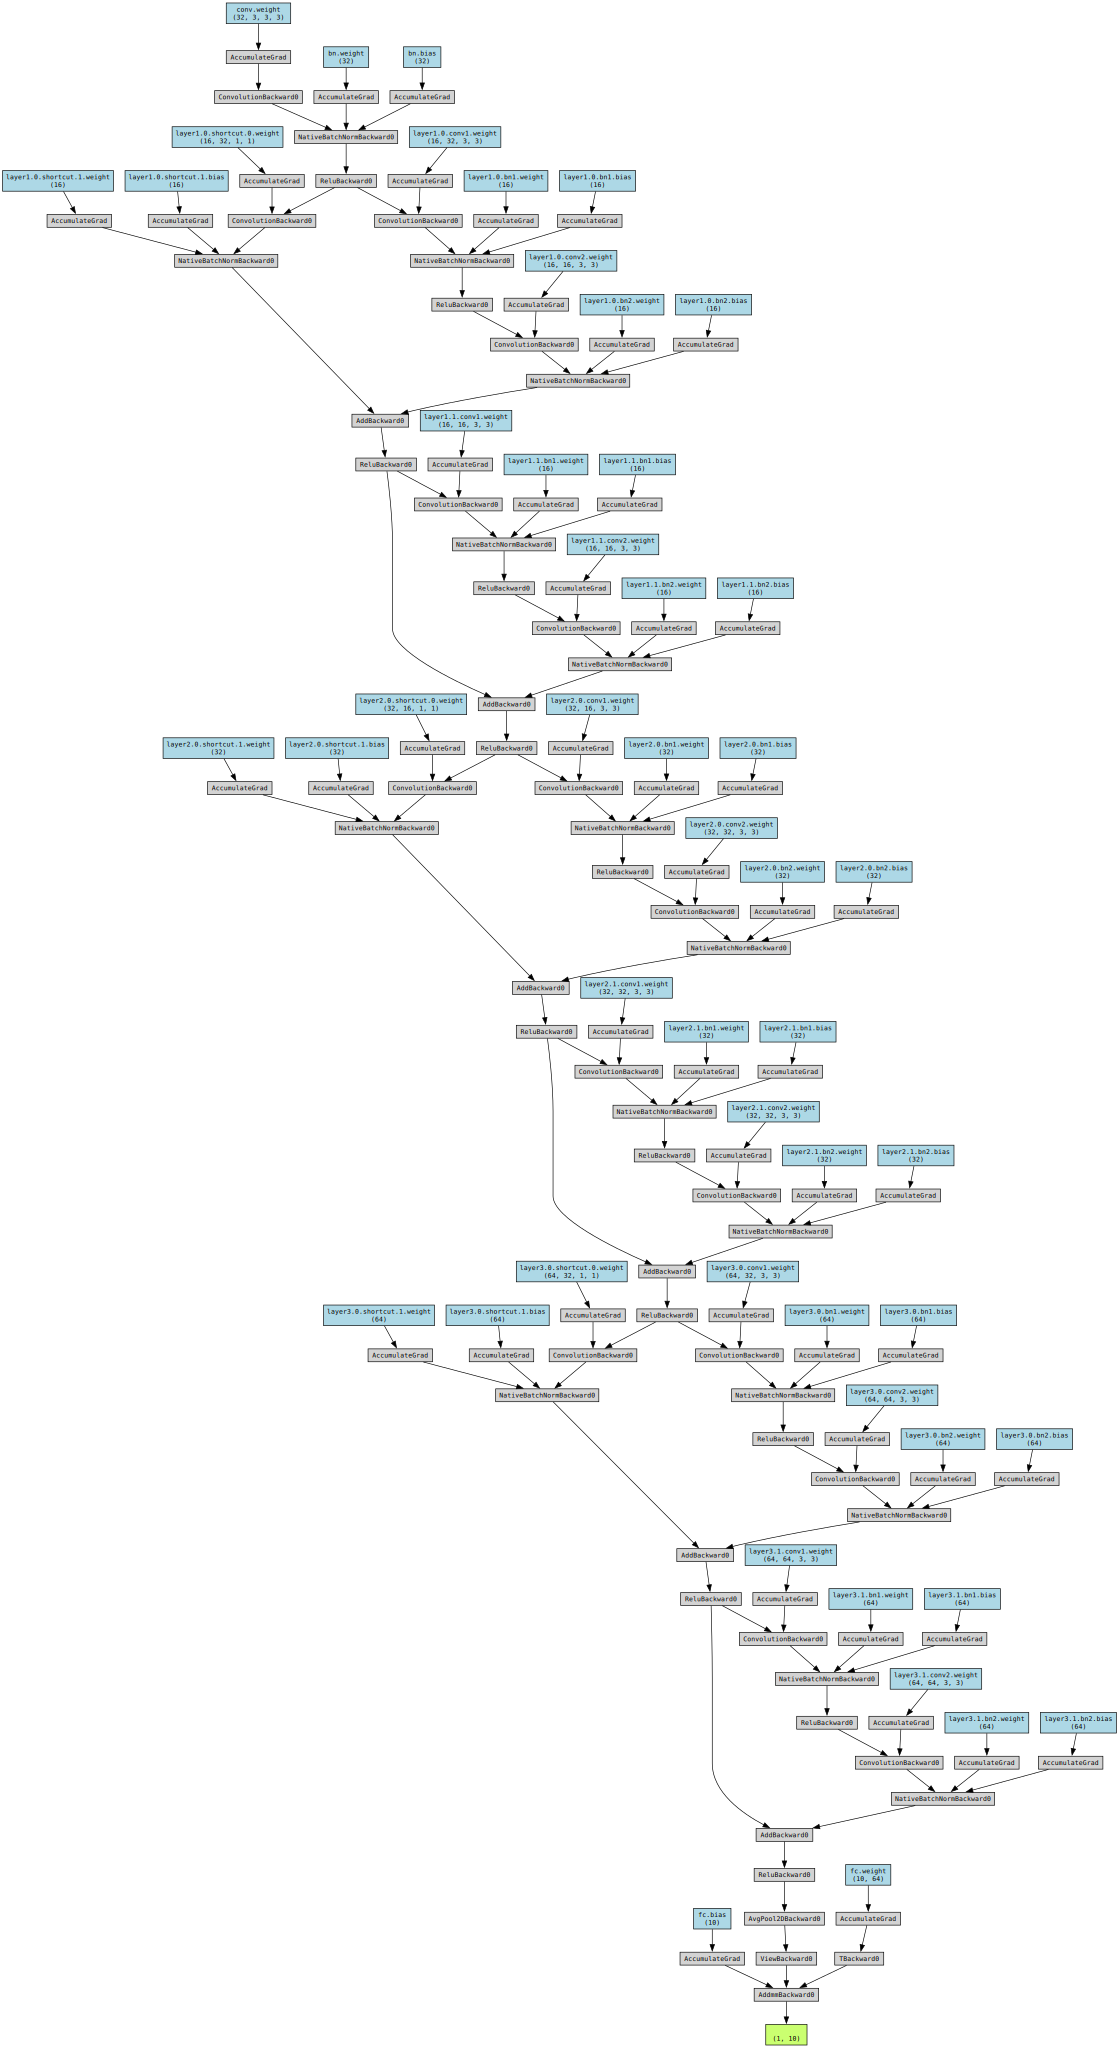

In [7]:
# Visualize the model
make_dot(combined_model(torch.randn(1, 3, 32, 32)), params=dict(combined_model.named_parameters()))